In [1]:
import rockpool
print(f'Rockpool version {rockpool.__version__}')

import samna
print(f'Samna version {samna.__version__}')

# from rockpool.devices.xylo.syns63300 import mapper
from rockpool.devices.xylo.syns65302 import XyloSamna, config_from_specification, mapper, XyloSim, XyloSamnaPDM
from rockpool.devices.xylo.syns65302 import xylo_a3_devkit_utils as hdkutils
from rockpool.devices.xylo.syns65302.afe import PDM_SAMPLING_RATE

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize

from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np
import matplotlib.pyplot as plt

import time

from tqdm.autonotebook import tqdm

/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.
  obj = getattr(themodule, elem)


Rockpool version 2.7.dev
Samna version 0.37.10.34+g8e0ba2872.dirty


WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns61201/xylo_samna.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]
  from tqdm.autonotebook import tqdm



from samna.xyloA3.configuration import InputInterfaceConfig


In [2]:
hdks, modules, versions = find_xylo_hdks()

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xa3_node = xylo

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`


In [3]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 32)),
    LIF(32),
)
net

ModSequential  with shape (16, 32) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 32)
    LIF '3_LIF' with shape (32, 32)
}

In [4]:
net[0].weight *= 0.05

In [5]:
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

print(config)

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_mapper.py:56: DRCWarning: Xylo-A3 only supports up to 16 output channels. The network requires 32 output channels.
  warnings.warn(
 [py.warnings]
  warnings.warn(



xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 40 -14 65 -64 -127 -126 32 -111 -77 -126 67 -127 10 -29 -40 7 127 63 118 -85 -47 -16 -1 -23 92 68 14 37 -112 72 -33 -115 -103 49 -88 -36 -88 -120 -100 -8 -58 -61 98 -62 -85 -86 -127 -125 -92 -32 79 49 -61 103 -111 -55 84 79 125 29 -45 -13 -109 -109 59 126 100 -43 26 79 70 18 -80 13 44 -20 67 26 23 7 -42 -10 -27 -118 -77 38 9 21 -40 62 -110 -77 -49 -12 -2 -91 -12 31 -99 -52 -52 -40 127 39 66 -48 85 -90 -118 -21 32 40 -127 -114 -35 127 -53 -102 -11 -11 42 35 92 -72 -81 -127 32 -14 83 -126 108 -84 25 -101 29 -45 -71 -57 8 -6 27 18 -1 17 -86 22 113 -80 122 31 107 119 -51 31 -40 4 -43 19 118 -56 -101 24 -75 -26 -94 -84 -36 81 -41 41 -117 111 -92 114 -8 -34 -13 79 33 124 29 127 119 45 -89 -56 26 86 -101 -86 -68 66 -126 -13 -102 33 -2 -8 61 18 53 -15 -74 

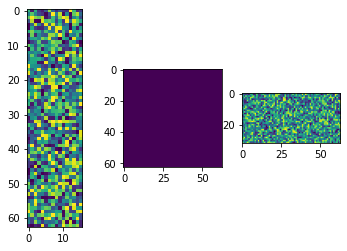

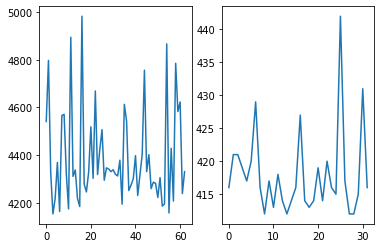

In [6]:
plt.subplot(1, 3, 1)
plt.imshow(np.array(config.input.weights).T)
plt.subplot(1, 3, 2)
plt.imshow(np.array(config.hidden.weights).T)
plt.subplot(1, 3, 3)
plt.imshow(np.array(config.readout.weights).T)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(spec['threshold'])
plt.subplot(1, 2, 2)
plt.plot(spec['threshold_out'])


In [7]:
# - Create a Xylo module with PDM input
dn = False
xmod = XyloSamnaPDM(xa3_node, config, dt=1024e-6, dn_active = dn)

configurarion updated


In [8]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 40 -14 65 -64 -127 -126 32 -111 -77 -126 67 -127 10 -29 -40 7 127 63 118 -85 -47 -16 -1 -23 92 68 14 37 -112 72 -33 -115 -103 49 -88 -36 -88 -120 -100 -8 -58 -61 98 -62 -85 -86 -127 -125 -92 -32 79 49 -61 103 -111 -55 84 79 125 29 -45 -13 -109 -109 59 126 100 -43 26 79 70 18 -80 13 44 -20 67 26 23 7 -42 -10 -27 -118 -77 38 9 21 -40 62 -110 -77 -49 -12 -2 -91 -12 31 -99 -52 -52 -40 127 39 66 -48 85 -90 -118 -21 32 40 -127 -114 -35 127 -53 -102 -11 -11 42 35 92 -72 -81 -127 32 -14 83 -126 108 -84 25 -101 29 -45 -71 -57 8 -6 27 18 -1 17 -86 22 113 -80 122 31 107 119 -51 31 -40 4 -43 19 118 -56 -101 24 -75 -26 -94 -84 -36 81 -41 41 -117 111 -92 114 -8 -34 -13 79 33 124 29 127 119 45 -89 -56 26 86 -101 -86 -68 66 -126 -13 -102 33 -2 -8 61 18 53 -15 -74 

In [9]:
hdkutils.is_xylo_ready(xmod._read_buffer, xmod._write_buffer)

0

In [10]:
config.operation_mode = samna.xyloAudio3.OperationMode.Manual

# config.debug.clock_enable                                    = True
# config.debug.always_update_omp_stat                          = True
# config.digital_frontend.filter_bank.dn_enable                = False
# config.digital_frontend.filter_bank.use_global_iaf_threshold = False
# config.digital_frontend.pdm_preprocessing.clock_direction    = 1
# config.digital_frontend.pdm_preprocessing.clock_edge         = 0
# config.digital_frontend.bfi_enable                           = True
# config.debug.enable_sdm                                      = True
# config.debug.sdm_module_clock                                = 24
# config.digital_frontend.mode = samna.xyloAudio3.DigitalFrontendMode.Pdm
# config.time_resolution_wrap = 0
# config.debug.debug_status_update_enable = 1
# config.debug.debug_input_enable = 1
# config.debug.monitor_signals_enable = 1
# # 0: input for Xylo, 1: Xylo output
# config.digital_frontend.pdm_preprocessing.clock_direction = 1
# # 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
# config.digital_frontend.pdm_preprocessing.clock_edge = 1

# config.digital_frontend.filter_bank.use_global_iaf_threshold = 1

# config.debug.enable_i2c = 1
# config.debug.enable_sdm = 1

# # config.debug.i2c_clock_freq_div = 24
# config.debug.sdm_module_clock = 48

# # config.debug.enable_adc = 1
# # config.debug.enable_spk2saer = 0
# # config.debug.enable_ana_testmode_control = 0
# # config.debug.enable_sadc_if = 0

# # config.debug.i2cClockFreqDiv;
# # config.debug.adcModuleClock;
# # config.debug.spk2saerModuleClock;

# # others for test
# config.debug.saer_if_enable = 0
# # config.hidden.aliasing = 1
# # config.bias_enable = 1
# config.debug.always_update_omp_stat = 1

# print(config)

In [11]:
# - Encode a PDM input chirp
from rockpool.devices.xylo.syns65302 import AFESimPDM

from scipy.signal import chirp

pdm_sr = PDM_SAMPLING_RATE
net_dt = 1024e-6
audio_sr = PDM_SAMPLING_RATE # 48e3

afesim_pdm = AFESimPDM.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    # spike_gen_mode="threshold",
    # fixed_threshold_vec = [2**25 for i in range(16)],
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=net_dt,
)


# afesim_pdm = AFESimPDM.from_specification(
#     select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
#     # spike_gen_mode="divisive_norm",
#     spike_gen_mode="threshold",
#     fixed_threshold_vec = [2**25 for i in range(16)],
#     rate_scale_factor=63,
#     low_pass_averaging_window=84e-3,
#     dn_EPS=1,
#     # fixed_threshold_vec=None,
#     dt=net_dt,
# )

dur = 200e-3
# dur = 1000e-3

T = int(audio_sr * dur)
f_start = 1000
f_end = 20e3
times = np.arange(0, T) / audio_sr
signal = chirp(times, f_start, T/audio_sr, f_end, method='linear', phi = 90)
# signal = np.sin(2 * np.pi * f_start * times)

__scale = 0.95
out_pdm, state_pdm, rec_pdm = afesim_pdm((signal * __scale, audio_sr))

WARNING    /tmp/ipykernel_205955/727471033.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)
 [py.warnings]
  plt.subplot(4,4,i+1)



(9774, 16)


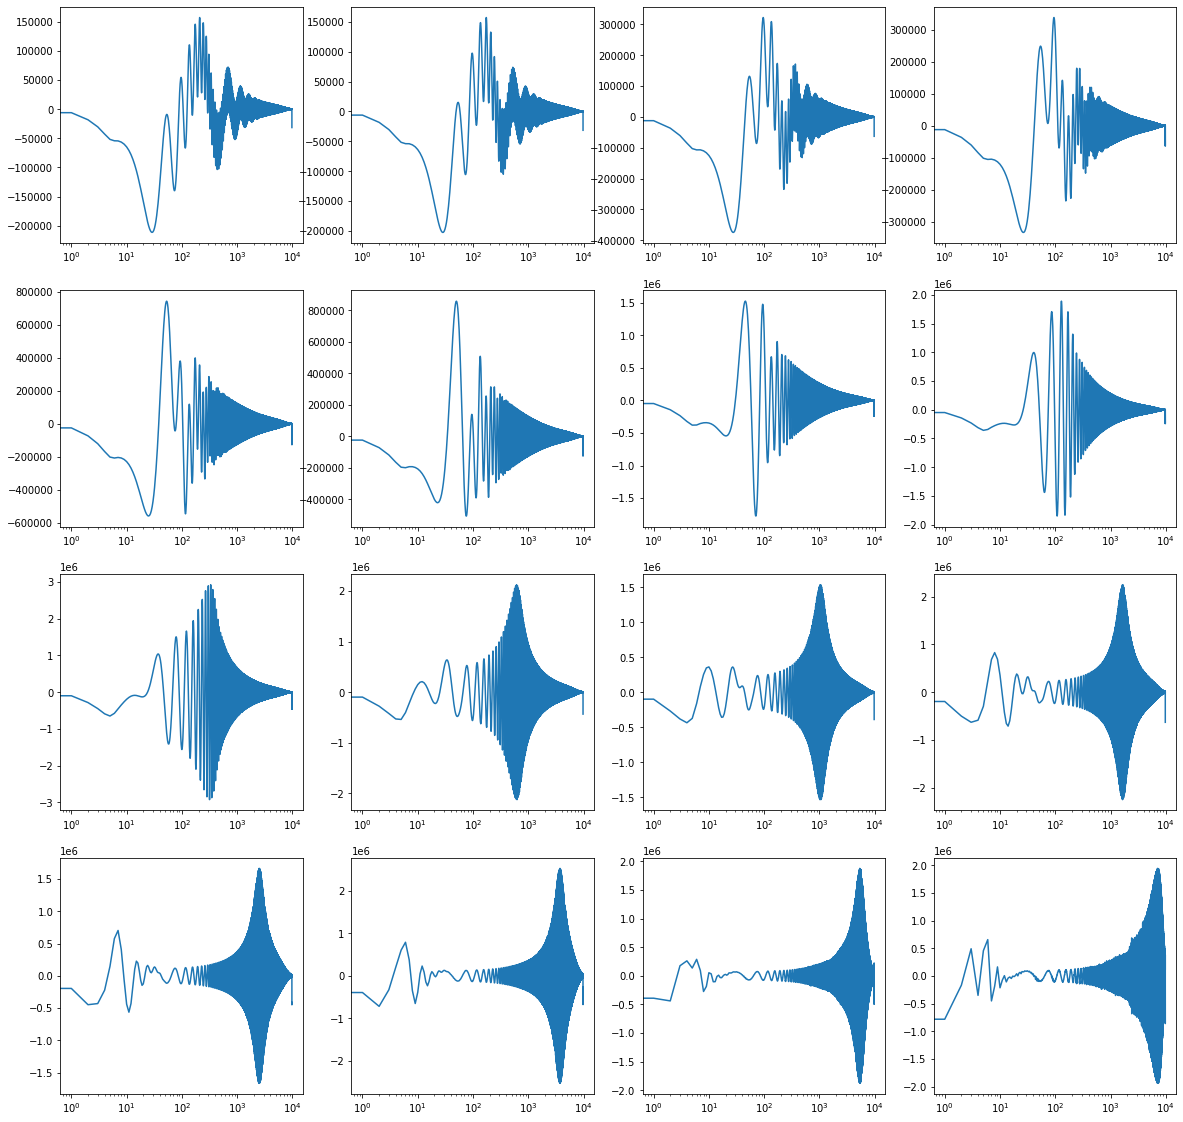

In [12]:
rec_pdm.keys()
filter_out = rec_pdm['1_ChipButterworth_output']
filter_in = rec_pdm['0_PDMADC_output']
plt.figure(figsize=(20, 20))
np.savetxt('filter_in.txt', filter_in, fmt = '%10d')
np.savetxt('filter_out.txt', filter_out, fmt='%10d')
plt.plot(filter_in)
plt.plot(filter_out); plt.legend(np.arange(16))
print(np.shape(filter_out))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.semilogx(filter_out[:,i])
# np.shape(rec_pdm['1_ChipButterworth_output'])
# rec_pdm['2_DivisiveNormalization']
# np.shape(rec_pdm['0_PDMADC_output'])

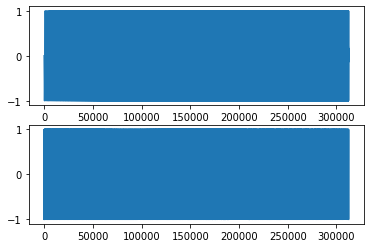

In [13]:
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.subplot(2, 1, 2)
plt.plot(rec_pdm['0_PDMADC']['0_MicrophonePDM_output'])

In [14]:
# def read_register(addr):
#     xmod._write_buffer.write([samna.xyloAudio3.event.ReadRegisterValue(address=addr)])
#     events = xmod._read_buffer.get_n_events(1, 3000)
#     print(events)
#     assert len(events) == 1
#     return [events[0].data]
    
# read_register(0x0153) #reg.stat2

In [15]:
input_pdm = (rec_pdm['0_PDMADC']['0_MicrophonePDM_output'] + 1) / 2
out, _, rd = xmod(input_pdm, record = True)

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_samna_pdm.py:235: UserWarning: Input PDM audio trace does not fit evenly into `dt`. Audio will be trimmed at the end of the sample. input size: 312500; PDM_samples_per_dt: 1600.
  warn(
 [py.warnings]
  warn(



  0%|          | 0/195 [00:00<?, ?it/s]

In [16]:
print(out)

[[False False False ... False False False]
 [False False  True ... False False False]
 [False False  True ... False  True  True]
 ...
 [False False  True ... False  True  True]
 [False False  True ... False  True  True]
 [False False  True ... False  True  True]]


In [17]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 40 -14 65 -64 -127 -126 32 -111 -77 -126 67 -127 10 -29 -40 7 127 63 118 -85 -47 -16 -1 -23 92 68 14 37 -112 72 -33 -115 -103 49 -88 -36 -88 -120 -100 -8 -58 -61 98 -62 -85 -86 -127 -125 -92 -32 79 49 -61 103 -111 -55 84 79 125 29 -45 -13 -109 -109 59 126 100 -43 26 79 70 18 -80 13 44 -20 67 26 23 7 -42 -10 -27 -118 -77 38 9 21 -40 62 -110 -77 -49 -12 -2 -91 -12 31 -99 -52 -52 -40 127 39 66 -48 85 -90 -118 -21 32 40 -127 -114 -35 127 -53 -102 -11 -11 42 35 92 -72 -81 -127 32 -14 83 -126 108 -84 25 -101 29 -45 -71 -57 8 -6 27 18 -1 17 -86 22 113 -80 122 31 107 119 -51 31 -40 4 -43 19 118 -56 -101 24 -75 -26 -94 -84 -36 81 -41 41 -117 111 -92 114 -8 -34 -13 79 33 124 29 127 119 45 -89 -56 26 86 -101 -86 -68 66 -126 -13 -102 33 -2 -8 61 18 53 -15 -74 

In [18]:
# np.savetxt('input_pdm.txt',input_pdm, fmt= '%d')

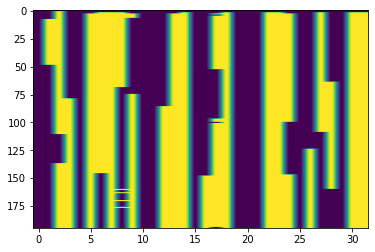

In [19]:
rd.keys()
np.shape(out)
plt.imshow(out, aspect = 'auto')

In [20]:
rd.keys()
print(np.shape(rd['Spikes_in']))

(195, 16)


In [21]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 40 -14 65 -64 -127 -126 32 -111 -77 -126 67 -127 10 -29 -40 7 127 63 118 -85 -47 -16 -1 -23 92 68 14 37 -112 72 -33 -115 -103 49 -88 -36 -88 -120 -100 -8 -58 -61 98 -62 -85 -86 -127 -125 -92 -32 79 49 -61 103 -111 -55 84 79 125 29 -45 -13 -109 -109 59 126 100 -43 26 79 70 18 -80 13 44 -20 67 26 23 7 -42 -10 -27 -118 -77 38 9 21 -40 62 -110 -77 -49 -12 -2 -91 -12 31 -99 -52 -52 -40 127 39 66 -48 85 -90 -118 -21 32 40 -127 -114 -35 127 -53 -102 -11 -11 42 35 92 -72 -81 -127 32 -14 83 -126 108 -84 25 -101 29 -45 -71 -57 8 -6 27 18 -1 17 -86 22 113 -80 122 31 107 119 -51 31 -40 4 -43 19 118 -56 -101 24 -75 -26 -94 -84 -36 81 -41 41 -117 111 -92 114 -8 -34 -13 79 33 124 29 127 119 45 -89 -56 26 86 -101 -86 -68 66 -126 -13 -102 33 -2 -8 61 18 53 -15 -74 

In [22]:
# AFE_output = rd['Spikes_in']
# AFESim_output = rec_pdm['3_Raster_output']
# print(rec_pdm.keys())
dn_output = rec_pdm['2_DivisiveNormalization_output']

np.savetxt('dn_out_bin.txt', dn_output, fmt='%5d')
# dn_out = dn_output @ np.array([2**i for i in range(16)])

# np.savetxt('dn_out.txt', dn_out, fmt='%04x')
# print(dn_out)
# print(np.shape(dn_out))

# print(np.shape(rec_pdm['2_DivisiveNormalization_output']))
# np.savetxt('AFE_output.txt', AFE_output, fmt='%6d')
# np.savetxt('AFESim_output.txt', AFESim_output, fmt='%6d')

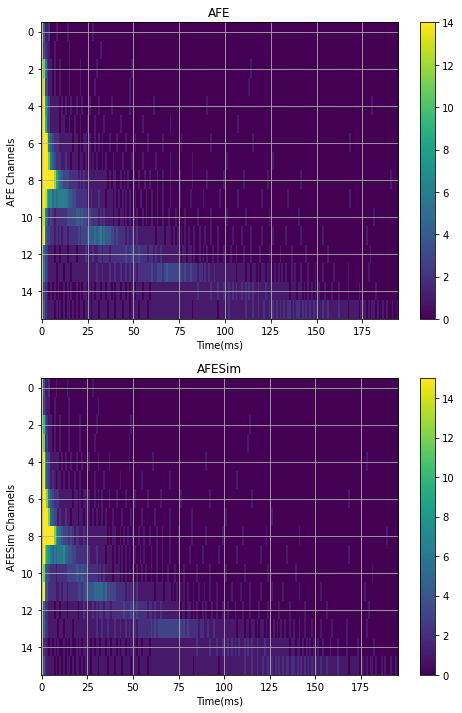

In [23]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.imshow(rd['Spikes_in'].T, aspect = 'auto', interpolation='none'); plt.colorbar();  plt.grid(True)
plt.xlabel('Time(ms)'); plt.ylabel('AFE Channels')
plt.title('AFE')
plt.clim([0,14]);


plt.subplot(212)
plt.imshow(rec_pdm['3_Raster_output'].T, aspect ='auto', interpolation='none'); plt.colorbar();  plt.grid(True)
# plt.clim([0,3]);
plt.xlabel('Time(ms)'); plt.ylabel('AFESim Channels')
plt.title('AFESim')
plt.savefig('figs/' + 'dur='+str(dur).replace('.', '_') + 'With_DN_Chirp_afe_vs_afeSim_modified.png')


[ 130.  125.  205.  205.  310.  310.  510.  580.  990.  885.  690. 1015.
  740. 1065.  780. 1030.]
[ 130.  125.  215.  215.  315.  315.  515.  580.  990.  890.  700. 1015.
  745. 1070.  785. 1030.]
[0.0, 0.0, 0.04878048780487805, 0.04878048780487805, 0.016129032258064516, 0.016129032258064516, 0.00980392156862745, 0.0, 0.0, 0.005649717514124294, 0.014492753623188406, 0.0, 0.006756756756756757, 0.004694835680751174, 0.00641025641025641, 0.0]


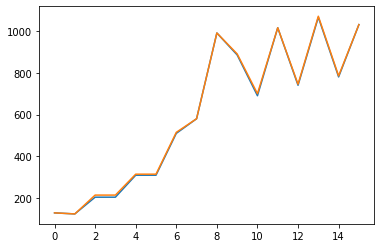

In [24]:
### for AFESim
a = np.sum(rec_pdm['3_Raster_output'].T, axis=1)/dur
print(a)

### for AFE
b = np.sum(rd['Spikes_in'].T, axis=1)/dur
print(b)

plt.plot(a)
plt.plot(b)

print([abs(i-j)/i for i,j in zip(a,b)])

In [25]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 40 -14 65 -64 -127 -126 32 -111 -77 -126 67 -127 10 -29 -40 7 127 63 118 -85 -47 -16 -1 -23 92 68 14 37 -112 72 -33 -115 -103 49 -88 -36 -88 -120 -100 -8 -58 -61 98 -62 -85 -86 -127 -125 -92 -32 79 49 -61 103 -111 -55 84 79 125 29 -45 -13 -109 -109 59 126 100 -43 26 79 70 18 -80 13 44 -20 67 26 23 7 -42 -10 -27 -118 -77 38 9 21 -40 62 -110 -77 -49 -12 -2 -91 -12 31 -99 -52 -52 -40 127 39 66 -48 85 -90 -118 -21 32 40 -127 -114 -35 127 -53 -102 -11 -11 42 35 92 -72 -81 -127 32 -14 83 -126 108 -84 25 -101 29 -45 -71 -57 8 -6 27 18 -1 17 -86 22 113 -80 122 31 107 119 -51 31 -40 4 -43 19 118 -56 -101 24 -75 -26 -94 -84 -36 81 -41 41 -117 111 -92 114 -8 -34 -13 79 33 124 29 127 119 45 -89 -56 26 86 -101 -86 -68 66 -126 -13 -102 33 -2 -8 61 18 53 -15 -74 